## Develop approach to examine oxygen-percentiles

Following [Sohail et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091439). **NOTE : need to check how to incorporate compressibility, i.e. use of *in situ* density.**

Ocean volume bounded by surfaces of tracer $\phi$:
$$\mathcal{V}(\phi^*,t) = \iiint_{\phi(x,y,z,t)>\phi^*}dxdydz$$
Tracer content/inventory ($\phi$) bounded by surface of tracer $\phi$:
$$\Phi(\phi^*,t) = \int_0^{\mathcal{V}(\phi^*,t)}\rho(x,y,z,t)\,\phi(x,y,z,t)d\mathcal{V}$$
Bounding tracer value of volume $\mathcal{V}$:
$$\mathcal{V}(\phi^*,t)\Leftrightarrow \phi^{\mathcal{V}}(\mathcal{V},t)$$
Tracer-percentile:
$$p(\phi^*,t) = 100*\mathcal{V}(\phi^*,t)/V_T$$
Tracer inventory as a function of tracer-percentile is:
$$\Phi(p,t) = 0.01V_T\int_0^p\rho(p,t)\phi^p(p,t)dp$$
where $\phi^p(p,t) \equiv \phi^{\mathcal{V}}(\mathcal{V},t)$ at $\mathcal{V}=0.01 \times p \times V_T$

In [1]:
import xarray as xr
import cftime
import utils.geo as geo
from xhistogram.xarray import histogram
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
rootdir = '/projects/SOCCOM/datasets/gobai-o2/'
filename = 'GOBAI-O2-v1.0_processed.zarr'
ds = xr.open_zarr(rootdir+filename)
grid = xr.open_dataset(rootdir+'regular_grid.nc')

In [3]:
grid['volcello']=grid['rC']*grid['dp']

In [4]:
oxy_bins = np.array(np.linspace(0,400,400))
dovals = np.diff(oxy_bins)

In [5]:
hs = histogram(ds['oxy'],bins=[oxy_bins],weights=grid['volcello'],dim=['lon','lat','pres'])
# Replace oxy_bin coordinate with upper bound of bin
hs = hs.assign_coords({'oxy_bin':oxy_bins[1:]})
# Normalize each bin by bin width
doxy = xr.DataArray(dovals,dims='oxy_bin',coords={'oxy_bin':hs['oxy_bin']})
hs = hs/doxy

In [6]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 28.83 s


In [7]:
t1 = ['2005','2009']
t2 = ['2015','2019']
t1slice = slice(t1[0]+'-01-01',t1[1]+'-12-31')
t2slice = slice(t2[0]+'-01-01',t2[1]+'-12-31')
t1label = t1[0]+' to '+t1[1]
t2label = t2[0]+' to '+t2[1]
t1color='tab:blue'
t2color='tab:orange'
dt = cftime.datetime(int(t2[1]),12,31)-cftime.datetime(int(t1[1]),12,31)
dt = dt.days*24*60*60

In [17]:
hs_frac = 100*hs.cumsum('oxy_bin')/hs.sum('oxy_bin')
hs_frac_t1 = hs_frac.sel(time=t1slice).mean('time')
hs_frac_t2 = hs_frac.sel(time=t2slice).mean('time')

In [18]:
def invert_and_interpolate_histogram(hs,percentiles=None):
    if percentiles is None:
        percentiles = np.linspace(1,100,100)
    dim = hs.dims[0]
    # Invert histogram
    inverted = xr.DataArray(hs[dim],dims='percentile',coords={'percentile':hs.values})
    # Find points where percentile coordinate is not monotonically increasing
    diffvals=inverted['percentile'].diff('percentile').values
    diffvals=np.append(1,diffvals) # Append value to start to align difference with latter bin
    diff = xr.DataArray(diffvals,dims=['percentile'],coords={'percentile':inverted['percentile']})
    # Drop points in original histogram where percentile not monotonically increasing
    # (necessary to interpolate onto uniform grid)
    inverted_dropped = inverted.where(diff>0,drop=True)
    # Interpolate onto uniform percentiles
    inverted_uniform = inverted_dropped.interp({'percentile':percentiles})
    return inverted_uniform

In [19]:
inv_t1 = invert_and_interpolate_histogram(hs_frac_t1)
inv_t2 = invert_and_interpolate_histogram(hs_frac_t2)

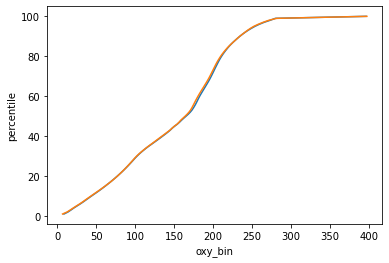

In [20]:
inv_t1.plot(y='percentile')
inv_t2.plot(y='percentile')

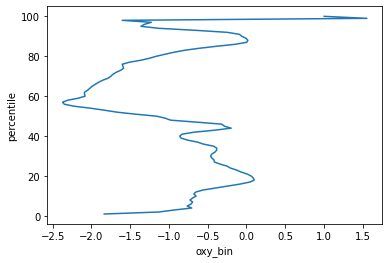

In [21]:
(inv_t2-inv_t1).plot(y='percentile')

In [171]:
(inv_t2-inv_t1).sum('percentile')

<xarray.DataArray 'oxy_bin' ()>
array(-90.15964513)